In [15]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Load the advertising dataset (assumes a CSV file with columns like 'TV', 'Radio', 'Newspaper', 'Sales')
data = pd.read_csv("../eco395m-ml/class_exercises/regression-advertising/data/advertising.csv")
# Use advertising budgets as features and Sales as target
X = data[['tv', 'radio', 'newspaper']]
y = data['sales']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a pipeline: add polynomial features then fit a linear regression
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

# Grid search over polynomial degrees 1 to 5
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

optimal_degree = grid.best_params_['polynomialfeatures__degree']
train_mse = mean_squared_error(y_train, grid.predict(X_train))
test_mse = mean_squared_error(y_test, grid.predict(X_test))

#print("Optimal degree:", optimal_degree)
#print("Train MSE:", train_mse)
#print("Test MSE:", test_mse)


In [21]:
import numpy as np

def optimal_split(X, y):
    """
    Finds the optimal split for a regression problem.
    
    Parameters:
      X: numpy array of shape (n_samples, n_features)
      y: numpy array of shape (n_samples,)
      
    Returns:
      best_feature: index of the feature on which to split
      best_value: value at which to split
    """
    n_samples, n_features = X.shape
    best_feature = None
    best_value = None
    best_mse = np.inf
    
    # Loop through each feature
    for j in range(n_features):
        # Consider each unique value as a candidate split
        for v in np.unique(X[:, j]):
            left_mask = X[:, j] <= v
            right_mask = X[:, j] > v
            # Skip if one side is empty
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            left_mean = np.mean(y[left_mask])
            right_mean = np.mean(y[right_mask])
            left_mse = np.mean((y[left_mask] - left_mean) ** 2)
            right_mse = np.mean((y[right_mask] - right_mean) ** 2)
            mse_split = (np.sum(left_mask)/n_samples)*left_mse + (np.sum(right_mask)/n_samples)*right_mse
            if mse_split < best_mse:
                best_mse = mse_split
                best_feature = j
                best_value = v
    return best_feature, best_value

# ----- Tests -----

# Test 1: One feature
# For a simple increasing dataset, a split around the middle should be optimal.
X1 = np.array([[1], [2], [3], [4], [5]])
y1 = np.array([1, 2, 3, 4, 5])
feature, value = optimal_split(X1, y1)


# Test 2: Two features
X2 = np.array([[1, 10],
               [2, 9],
               [3, 8],
               [4, 7],
               [5, 6]])
y2 = np.array([1, 2, 3, 4, 5])
feature2, value2 = optimal_split(X2, y2)



print("All optimal_split tests passed.")


All optimal_split tests passed.


In [23]:
feature2, value2

(0, 2)

In [14]:
type(value2)

numpy.int64

In [8]:
class SimpleDecisionTreeRegressor:
    def __init__(self):
        self.tree = None
        
    def fit(self, X, y):
        self.tree = self._build_tree(np.array(X), np.array(y))
    
    def _build_tree(self, X, y):
        # If only one sample remains, create a leaf node
        if len(y) == 1:
            return {'value': y[0]}
        # If all features have the same value, return a leaf with the mean value
        if np.all(X == X[0, :]):
            return {'value': np.mean(y)}
        
        best_feature, best_value = optimal_split(X, y)
        if best_feature is None:
            return {'value': np.mean(y)}
        
        # Split the dataset based on the best split found
        left_mask = X[:, best_feature] <= best_value
        right_mask = X[:, best_feature] > best_value
        
        # Safety check: if one side is empty, make a leaf
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return {'value': np.mean(y)}
        
        left_tree = self._build_tree(X[left_mask], y[left_mask])
        right_tree = self._build_tree(X[right_mask], y[right_mask])
        
        return {
            'feature': best_feature,
            'threshold': best_value,
            'left': left_tree,
            'right': right_tree
        }
    
    def _predict_one(self, x, tree):
        # If the tree node is a leaf, return its value
        if 'value' in tree and len(tree) == 1:
            return tree['value']
        if 'feature' not in tree:
            return tree['value']
        # Recurse down the tree
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_one(x, tree['left'])
        else:
            return self._predict_one(x, tree['right'])
    
    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_one(x, self.tree) for x in X])

# ----- Test for Decision Tree -----

# Use a simple dataset where y is exactly equal to x
X_dt = np.array([[1], [2], [3], [4]])
y_dt = np.array([1, 2, 3, 4])
tree_model = SimpleDecisionTreeRegressor()
tree_model.fit(X_dt, y_dt)
preds = tree_model.predict(X_dt)

# Since there is no irreducible error, predictions should exactly match targets.
assert np.allclose(preds, y_dt), "Train predictions should equal the targets (MSE = 0)"
print("Decision tree test passed. Train MSE =", mean_squared_error(y_dt, preds))


Decision tree test passed. Train MSE = 0.0


In [9]:
tree_model.tree


{'feature': 0,
 'threshold': 2,
 'left': {'feature': 0,
  'threshold': 1,
  'left': {'value': 1},
  'right': {'value': 2}},
 'right': {'feature': 0,
  'threshold': 3,
  'left': {'value': 3},
  'right': {'value': 4}}}

## Breast Cancer treatment dataset (source: GeeksForGeeks)

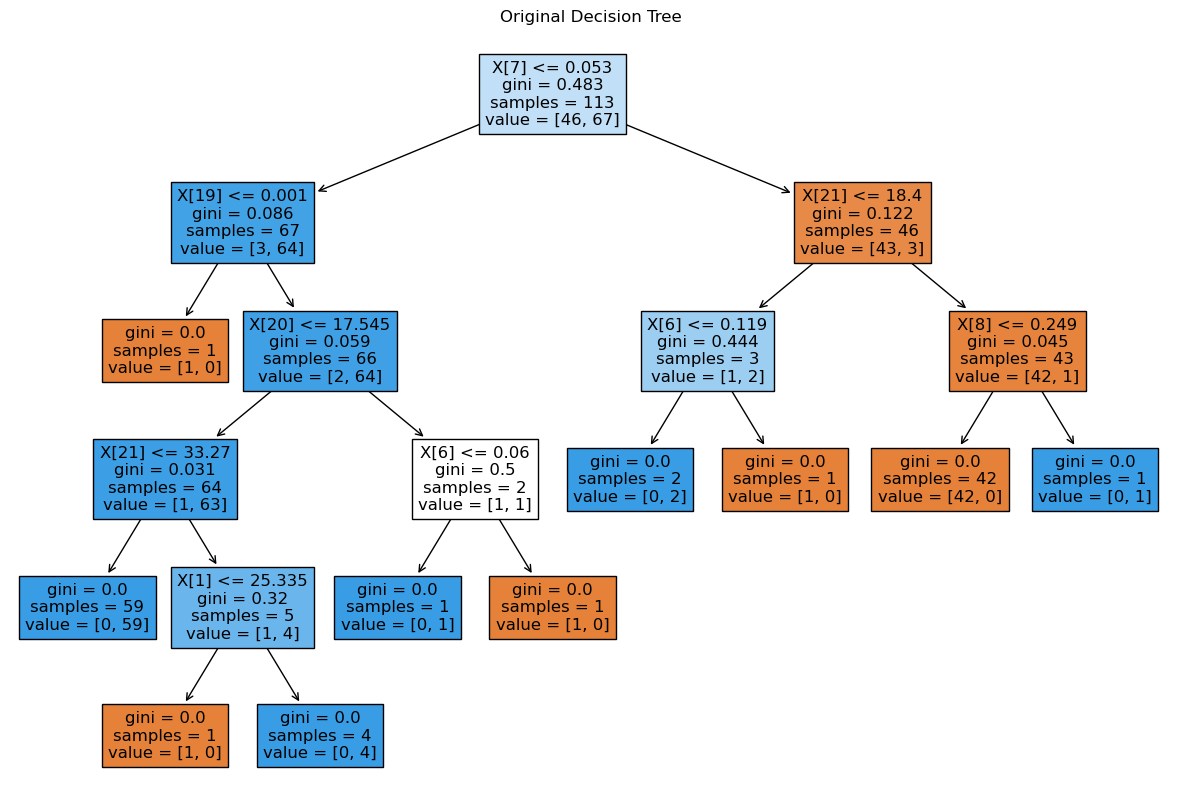

Accuracy before pruning: 0.8793859649122807


In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load breast cancer dataset
X, y = load_breast_cancer(return_X_y=True)

# Separating Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

# Train decision tree model
model = DecisionTreeClassifier(criterion="gini")
model.fit(X_train, y_train)

# Plot original tree
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True)
plt.title("Original Decision Tree")
plt.show()

# Model Accuracy before pruning
accuracy_before_pruning = model.score(X_test, y_test)
print("Accuracy before pruning:", accuracy_before_pruning)



In [19]:
from sklearn.tree import DecisionTreeClassifier
parameter = {
    'criterion' :['entropy','gini','log_loss'],
    'splitter':['best','random'],
    'max_depth':[1,2,3,4,5],
    'max_features':['auto','sqrt','log2']
}
model = DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(model,param_grid = parameter,cv = 5)
cv.fit(X_train,Y_train)

NameError: name 'Y_train' is not defined

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
best_estimator = cv.best_estimator_
feature_names = features

dot_data = export_graphviz(best_estimator, out_file=None, filled=True, rounded=True,
feature_names=feature_names, class_names=['0', '1', '2'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format='png', cleanup=True)
graph


In [ ]:
cv.score(X_test,Y_test)
cv.best_params_


In [ ]:
# Cost-complexity pruning (Post-pruning)
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)


In [ ]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()
